<a href="https://colab.research.google.com/github/mohannashahrad/Comp598_Project/blob/main/Notebooks/comp598_tfidf_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [33]:
import pandas as pd
import math
import json
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from matplotlib import pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Define Functions

In [2]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

def expandContractions(text,contractions_dict=contractions_dict):
    regex=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    def replace(match):
        return contractions_dict[match.group(0)]
    return regex.sub(replace, text)

# Loading the finalized dataset

In [3]:
url = 'https://raw.githubusercontent.com/mohannashahrad/Comp598_Project/main/data/final_labeled_data.csv'
df = pd.read_csv(url)
display(df.head(30))

,category,sentiment,text
0,infections,negative,B.C. counts 10 more deaths over weekend from C...
1,infections,negative,"Always deflection, never answers. And why is t..."
2,infections,neutral,"Covid 19 Update. Confirmed 4,323, No Change. ..."
3,infections,positive,"Less cases than yesterday, but still not good...."
4,infections,neutral,"COVID-19 in Sask.: 1,047 active cases, 150 pat..."
5,infections,negative,@RebeccaDeVaney1 Will be full of “vaxxed” unte...
6,infections,neutral,Here's @stephanielevitz on how the first day b...
7,infections,negative,Your @NiagarasNewRock 3pm news update:\r\n-Ont...
8,infections,neutral,"NSW records 180 new COVID-19 cases, one death ..."
9,infections,negative,"@KellDA @davenewworld_2 Covid cases were 2,315..."


# Pre-processing

##Lowercase 

In [4]:
df["text"] = df["text"].str.lower()
display(df.head(30))

,category,sentiment,text
0,infections,negative,b.c. counts 10 more deaths over weekend from c...
1,infections,negative,"always deflection, never answers. and why is t..."
2,infections,neutral,"covid 19 update. confirmed 4,323, no change. ..."
3,infections,positive,"less cases than yesterday, but still not good...."
4,infections,neutral,"covid-19 in sask.: 1,047 active cases, 150 pat..."
5,infections,negative,@rebeccadevaney1 will be full of “vaxxed” unte...
6,infections,neutral,here's @stephanielevitz on how the first day b...
7,infections,negative,your @niagarasnewrock 3pm news update:\r\n-ont...
8,infections,neutral,"nsw records 180 new covid-19 cases, one death ..."
9,infections,negative,"@kellda @davenewworld_2 covid cases were 2,315..."


##Expanding Contractions

In [5]:
df['text'] = df['text'].apply(lambda x:expandContractions(x))
display(df.head(30))

,category,sentiment,text
0,infections,negative,b.c. counts 10 more deaths over weekend from c...
1,infections,negative,"always deflection, never answers. and why is t..."
2,infections,neutral,"covid 19 update. confirmed 4,323, no change. ..."
3,infections,positive,"less cases than yesterday, but still not good...."
4,infections,neutral,"covid-19 in sask.: 1,047 active cases, 150 pat..."
5,infections,negative,@rebeccadevaney1 will be full of “vaxxed” unte...
6,infections,neutral,here is @stephanielevitz on how the first day ...
7,infections,negative,your @niagarasnewrock 3pm news update:\r\n-ont...
8,infections,neutral,"nsw records 180 new covid-19 cases, one death ..."
9,infections,negative,"@kellda @davenewworld_2 covid cases were 2,315..."


## Removing stopwords

In [6]:
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
display(df.head(30))

,category,sentiment,text
0,infections,negative,b.c. counts 10 deaths weekend covid-19 https:/...
1,infections,negative,"always deflection, never answers. goal reduce ..."
2,infections,neutral,"covid 19 update. confirmed 4,323, change. dece..."
3,infections,positive,"less cases yesterday, still good. solution = v..."
4,infections,neutral,"covid-19 sask.: 1,047 active cases, 150 patien..."
5,infections,negative,@rebeccadevaney1 full “vaxxed” untested covid ...
6,infections,neutral,@stephanielevitz first day back went erin o’to...
7,infections,negative,@niagarasnewrock 3pm news update: -ontario rep...
8,infections,neutral,"nsw records 180 new covid-19 cases, one death ..."
9,infections,negative,"@kellda @davenewworld_2 covid cases 2,315 cana..."


## Punctuation

In [7]:
df['text'] = df['text'].apply(lambda x:re.sub(r'[^\w\s]','', x))
display(df.head(30))

,category,sentiment,text
0,infections,negative,bc counts 10 deaths weekend covid19 httpstcouk...
1,infections,negative,always deflection never answers goal reduce co...
2,infections,neutral,covid 19 update confirmed 4323 change deceased...
3,infections,positive,less cases yesterday still good solution vacc...
4,infections,neutral,covid19 sask 1047 active cases 150 patients ho...
5,infections,negative,rebeccadevaney1 full vaxxed untested covid spr...
6,infections,neutral,stephanielevitz first day back went erin otool...
7,infections,negative,niagarasnewrock 3pm news update ontario report...
8,infections,neutral,nsw records 180 new covid19 cases one death ht...
9,infections,negative,kellda davenewworld_2 covid cases 2315 canada ...


##Removing extra spaces

In [8]:
df['text'] = df['text'].apply(lambda x:re.sub(' +',' ',x))
display(df.head(30))

,category,sentiment,text
0,infections,negative,bc counts 10 deaths weekend covid19 httpstcouk...
1,infections,negative,always deflection never answers goal reduce co...
2,infections,neutral,covid 19 update confirmed 4323 change deceased...
3,infections,positive,less cases yesterday still good solution vacci...
4,infections,neutral,covid19 sask 1047 active cases 150 patients ho...
5,infections,negative,rebeccadevaney1 full vaxxed untested covid spr...
6,infections,neutral,stephanielevitz first day back went erin otool...
7,infections,negative,niagarasnewrock 3pm news update ontario report...
8,infections,neutral,nsw records 180 new covid19 cases one death ht...
9,infections,negative,kellda davenewworld_2 covid cases 2315 canada ...


#Calculating TF-IDF

In [9]:
def filter_df_by_category(category):
  result = df[df['category'] == category]
  result.reset_index(drop=True, inplace=True)
  return result

def compute_tf_idf(category, data_dict, word):
    # tf = number of times the word is used in the same category
    tf = data_dict[category][word]
    # log [ (total number of categories) / (number of categoreis that use the word w)]
    idf = compute_idf(data_dict, word)
    return tf * idf

def compute_idf(data, word):
    total_num = 5
    categories_that_used_word = 0
    for c in data:
        if word in data[c]:
            categories_that_used_word += 1
    return math.log(total_num/categories_that_used_word,10)

def sort_result(result_dict, num_of_words):
    # Sorting the dictionary by value of tf-idf scores
    sorted_list = sorted(result_dict.items(), key=lambda x: x[1], reverse=True)
    result_list = []
    if len(sorted_list) < num_of_words:
        return result_list
    for i in range(num_of_words):
        result_list.append(sorted_list[i][0])
    return result_list        


In [10]:
# Creating a dictionary of frequencies per category 

categories = ['infections', 'pandemic effects', 'policy', 'science', 'vaccination']
freq_dict = {}
for c in categories:
  freq = filter_df_by_category(c)['text'].str.split(expand=True).stack().value_counts()
  freq_df = pd.DataFrame(freq).transpose()
  result = freq_df.to_dict('records')
  freq_dict[c] = result[0]
  print(result[0]) 

#print(freq_dict)  

{'covid': 47, 'covid19': 39, 'cases': 38, 'new': 25, 'vaccination': 22, 'deaths': 17, 'vaccinated': 14, 'people': 14, 'positive': 12, 'health': 11, 'fully': 10, 'bc': 9, 'via': 9, 'still': 8, 'number': 8, 'status': 8, 'ontario': 8, 'one': 8, 'death': 7, 'tests': 7, 'died': 6, 'pfizer': 6, 'amp': 6, 'reported': 6, 'day': 6, 'like': 6, 'mp': 6, 'weekend': 5, '2': 5, 'virus': 5, 'covid_parent': 5, 'would': 5, 'data': 5, 'see': 5, 'us': 5, 'reporting': 5, 'news': 5, 'year': 5, 'update': 5, 'due': 5, 'canada': 5, 'active': 4, 'otoole': 4, '10': 4, 'weeks': 4, '1052': 4, 'torontostar': 4, 'today': 4, 'rates': 4, 'icu': 4, 'tested': 4, 'infections': 4, 'without': 4, 'case': 4, 'sorry': 4, 'reports': 4, 'erin': 4, '627': 4, 'going': 4, 'vaxed': 4, 'official': 4, 'safe': 4, 'unknown': 4, 'first': 4, 'unvaccinated': 4, 'im': 4, 'kids': 4, 'good': 3, '3': 3, 'europe': 3, 'schools': 3, 'total': 3, 'less': 3, 'last': 3, 'eve': 3, 'dogs': 3, 'conservative': 3, 'yesterday': 3, 'around': 3, 'vancouver

## Calling TF-IDF functions

In [11]:
result_dict = {}
for c in categories:
  score_dict = {}
  for word in freq_dict[c]:
    score_dict[word] = compute_tf_idf(c, freq_dict, word)
  print(sorted(score_dict.items(), key=lambda x: x[1], reverse=True))  
  result_dict[c] = sort_result(score_dict, 10)

print(result_dict)    

[('covid_parent', 3.4948500216800937), ('1052', 2.795880017344075), ('erin', 2.795880017344075), ('627', 2.795880017344075), ('positive', 2.6621849953962764), ('mp', 2.387640052032226), ('eve', 2.0969100130080562), ('dogs', 2.0969100130080562), ('tory', 2.0969100130080562), ('loss', 2.0969100130080562), ('spotlight', 2.0969100130080562), ('blah', 2.0969100130080562), ('weekend', 1.989700043360188), ('reporting', 1.989700043360188), ('otoole', 1.5917600346881504), ('official', 1.5917600346881504), ('unknown', 1.5917600346881504), ('tests', 1.5529412473144946), ('british', 1.3979400086720375), ('columbia', 1.3979400086720375), ('286', 1.3979400086720375), ('goal', 1.3979400086720375), ('count', 1.3979400086720375), ('niagara', 1.3979400086720375), ('cdcofbc', 1.3979400086720375), ('relatively', 1.3979400086720375), ('castex', 1.3979400086720375), ('roman', 1.3979400086720375), ('senators', 1.3979400086720375), ('those', 1.3979400086720375), ('condolences', 1.3979400086720375), ('reported

#Plots and Results


In [13]:
result_df = pd.DataFrame.from_dict(result_dict)
display(result_df)

,infections,pandemic effects,policy,science,vaccination
0,covid_parent,stocks,proof,study,spots
1,1052,operation,aged,cell,3rd
2,erin,nftartist,approves,type,detailed
3,627,shipping,authorized,antibody,vhcon
4,positive,dark,asks,mrna,availability
5,mp,guilty,government,contraindications,aged
6,eve,piece,provincial,mixing,appointments
7,dogs,violence,approve,rna,toronto
8,tory,airborne,policy,adolescents,book
9,loss,women,bill,immune,date


In [42]:
def plot_sentiment_pie(df, category):
  plt.style.use('seaborn')
  sentiment_count_dict = df['sentiment'].value_counts().to_dict()
  sentiments = []
  counts = []
  for i in sentiment_count_dict:
    sentiments.append(i)
    counts.append(sentiment_count_dict[i])

  fig = plt.figure(figsize =(10, 7))
  plt.pie(counts, labels = sentiments, autopct='%.1f%%')
  fig.text(.5, .05, f'Sentiment Distributoin for {category} category', ha='center')
  plt.show()

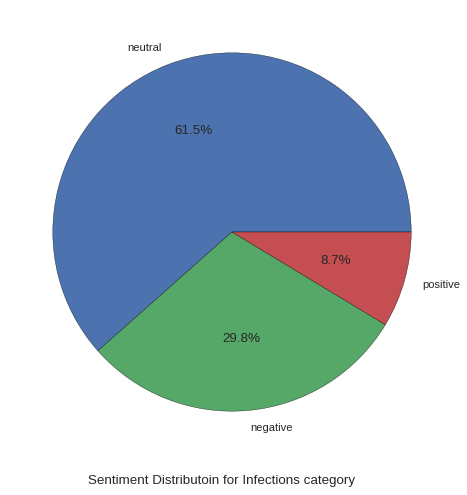

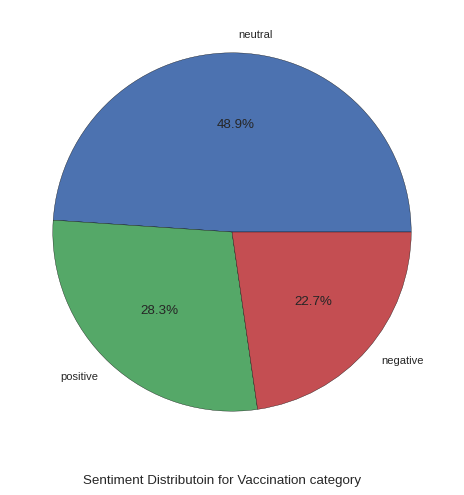

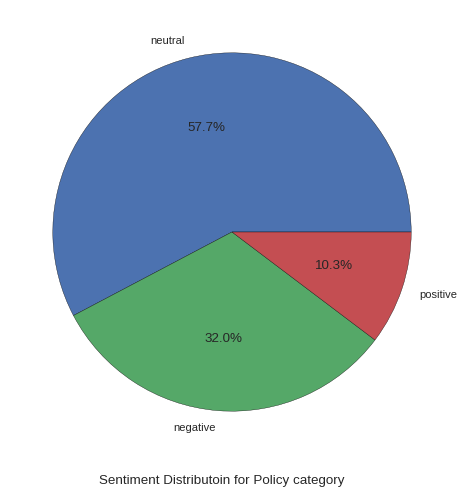

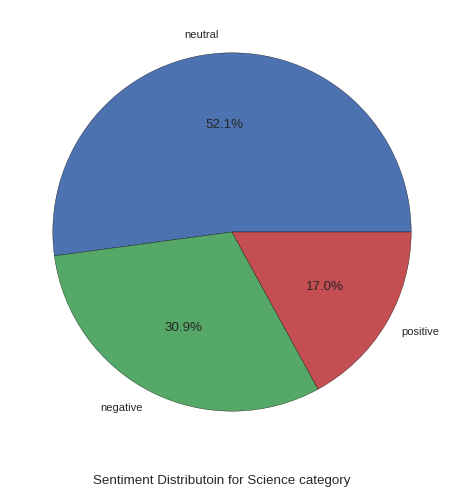

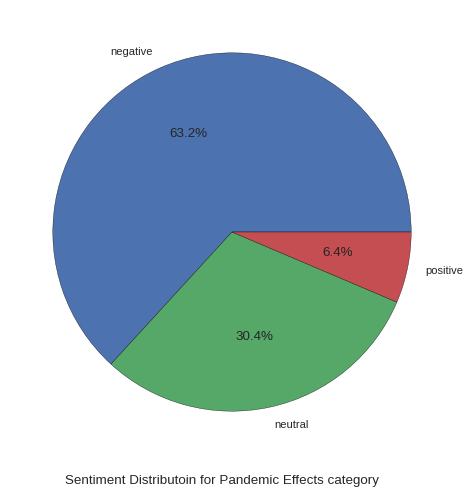

In [43]:
plot_sentiment_pie(df[df['category'] == 'infections'], 'Infections')
plot_sentiment_pie(df[df['category'] == 'vaccination'], 'Vaccination')
plot_sentiment_pie(df[df['category'] == 'policy'], 'Policy')
plot_sentiment_pie(df[df['category'] == 'science'], 'Science')
plot_sentiment_pie(df[df['category'] == 'pandemic effects'], 'Pandemic Effects')